In this notebook we will follow a [PyTorch tutorial](https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/) implementing [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) with CIFAR10.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# Hyper-parameters (attempt changing them later)
num_epochs = 80
learning_rate = 0.001

In [5]:
# Image preprocessing modules (see more about this later)
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

In [6]:
train_dataset = torchvision.datasets.CIFAR10(root='../cifar-10-batches-py/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../cifar-10-batches-py/',
                                            train=False, 
                                            transform=transforms.ToTensor())

100.0%

Extracting ../cifar-10-batches-py/cifar-10-python.tar.gz to ../cifar-10-batches-py/


In [7]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../cifar-10-batches-py/
    Split: Train
    StandardTransform
Transform: Compose(
               Pad(padding=4, fill=0, padding_mode=constant)
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(32, 32), padding=None)
               ToTensor()
           )

In [10]:
type(train_dataset)

torchvision.datasets.cifar.CIFAR10

In [12]:
train_dataset.data.shape

(50000, 32, 32, 3)

In [8]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../cifar-10-batches-py/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [13]:
test_dataset.data.shape

(10000, 32, 32, 3)

In [14]:
import matplotlib.pyplot as plt

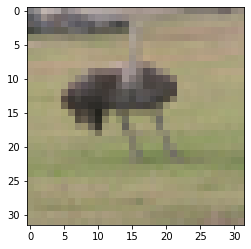

In [19]:
plt.figure()
plt.imshow(train_dataset.data[42])

In [32]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True) #Original tutorial has shuffle=True

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

In [33]:
train_loader

In [34]:
from resnet import conv3x3, ResidualBlock, ResNet

In [35]:
net_args = {
    "block" : ResidualBlock,
    "layers": [2, 2, 2]
}

model = ResNet(**net_args).to(device)

In [36]:
error = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [38]:
total_step = len(train_loader)
curr_lr = learning_rate

In [39]:
for epoch in range(num_epochs):
    print("Epoch ", epoch, " of ", num_epochs)
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch  0  of  80


RuntimeError: Given groups=1, weight of size [16, 1, 3, 3], expected input[100, 3, 32, 32] to have 1 channels, but got 3 channels instead

***
<span style="color: blue"><b>Study session observations: </b></span>

#### 16/07/2020:
Attempting to use the same resnet model to train CIFAR10.